In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
def get_normalized_data_MNIST():
    df = pd.read_csv('./train.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:]
    Ytest  = Y[-1000:]
    
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)

    np.place(std, std == 0, 1)

    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std
    
    Ytrain_ind = y2indicator(Ytrain)
    Ytest_ind = y2indicator(Ytest)
    
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)
    Ytrain = Ytrain.astype(np.float32)
    Ytest = Ytest.astype(np.float32)
    Ytrain_ind = Ytrain_ind.astype(np.float32)
    Ytest_ind= Ytest_ind.astype(np.float32)
    

    return Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind

In [3]:
def y2indicator(y):

    y = y.astype(np.int32)
    ind = np.zeros((len(y), 10))

    for i in range(len(y)):
        ind[i, y[i]] = 1
        
    return ind.astype(np.float32)

In [4]:
class HiddenLayers(object):
    def __init__(self, M1, M2, f):
        self.M1 = M1
        self.M2 = M2
        self.f = f
                
        W_init = np.random.randn(M1, M2)*np.sqrt(2/M1)
        b_init = np.zeros(M2)
        
        self.W = tf.Variable(W_init.astype(np.float32))
        self.b = tf.Variable(b_init.astype(np.float32))
        
    def forward(self, X):
        return self.f(tf.matmul(X, self.W)+ self.b)
        

In [5]:
class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes
            
    def fit(self, Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind, activation = tf.nn.relu, lr=1e-4, max_iter=15, batch_sz=500, print_period=100, show_fig=True):
        
        
        #initialize hidden layers
        N, D = Xtrain.shape
        K = Ytrain_ind.shape[1]
        
        
        M1 = D
        
        self.layers = []
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayers(M1, M2, activation)
            self.layers.append(h)
            M1 = M2
        
        #final layer
        h = HiddenLayers(M2, K, lambda x : x)
        self.layers.append(h)
        
        
        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
        
        
        Yish = self.forward(tfX)
        
        cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=tfT))
        
        train_op = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
        predict_op = tf.argmax(Yish, 1)
        
        n_batches = N // batch_sz
        costs = []
        
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)

            for i in range(max_iter):
                for j in range(n_batches):
                    Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
                    Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfT: Ybatch})
                    if j % print_period == 0:
                        test_cost = session.run(cost, feed_dict={tfX: Xtest, tfT: Ytest_ind})
                        prediction = session.run(predict_op, feed_dict={tfX: Xtest})
                        err = self.error_rate(prediction, Ytest)
                        print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                        costs.append(test_cost)

        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward(self, X):
        out = X
        for h in self.layers[:-1]:
            out = h.forward(out)
        out = self.layers[-1].forward(out)
        return out
    
    def error_rate(self, p, t):
        return np.mean(p != t)

In [6]:
def main():
    # step 1: get the data and define all the usual variables
    Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind = get_normalized_data_MNIST()

    ann = ANN([500, 300, 100])
    ann.fit(Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind)

Cost / err at iteration i=0, j=0: 2845.157 / 0.818
Cost / err at iteration i=1, j=0: 566.764 / 0.145
Cost / err at iteration i=2, j=0: 317.163 / 0.079
Cost / err at iteration i=3, j=0: 258.873 / 0.067
Cost / err at iteration i=4, j=0: 226.038 / 0.056
Cost / err at iteration i=5, j=0: 206.906 / 0.053
Cost / err at iteration i=6, j=0: 194.213 / 0.049
Cost / err at iteration i=7, j=0: 185.741 / 0.041
Cost / err at iteration i=8, j=0: 178.965 / 0.039
Cost / err at iteration i=9, j=0: 173.584 / 0.040
Cost / err at iteration i=10, j=0: 169.256 / 0.039
Cost / err at iteration i=11, j=0: 166.729 / 0.038
Cost / err at iteration i=12, j=0: 164.638 / 0.036
Cost / err at iteration i=13, j=0: 163.123 / 0.036
Cost / err at iteration i=14, j=0: 161.770 / 0.038


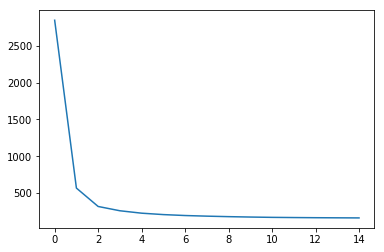

In [7]:
if __name__ == '__main__':
    main()